In [1]:
import pandas as pd
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
import numpy as np
import tensorflow as tf

In [2]:
data = pd.read_csv("UCF-crime-frames-descriptions-partitions.csv")

In [3]:
data.head(2)

,Unnamed: 0,frame,directory,class,Description,partition
0,0,Abuse001_x264.mp4_frame_000000.jpg,Abuse_frames,Normal,a man is standing in the middle of a room,train
1,1,Abuse001_x264.mp4_frame_000010.jpg,Abuse_frames,Normal,a man is standing in the middle of a room,train


In [4]:
train = data.loc[(data["partition"] == "train")]


In [5]:
val = data.loc[(data["partition"] == "validation")]


In [6]:
train.shape, val.shape

((124145, 6), (19330, 6))

In [7]:
def get_data(df):
    X = np.zeros((len(df), 1408))
    path = "d:/data/UCF-crime/Anomaly-Videos-frames-features"
    c = 0
    for _, f in df.iterrows():
        directory = f["directory"][:-7]
        X[c] = np.load(f"{path}/{directory}/{f['frame']}.npy")
        c += 1    
    y = list(df["class"])
    y = [labels[lbl] for lbl in y]    
    return X, np.array(y)

In [8]:
labels = {"Normal": 0,
          "Abuse": 1,
          "Arrest": 1,
          "Arson": 1,
          "Burglary": 1,
          "Explosion": 1,
          "Fighting": 1,
          "RoadAccidents": 1,
          "Shooting": 1,
          "Vandalism": 1
         }

In [9]:
V, y_val = get_data(val)

In [10]:
V.shape, y_val.shape

((19330, 1408), (19330,))

In [11]:
X, y = get_data(train)

In [12]:
X.shape, y.shape

((124145, 1408), (124145,))

In [30]:
model = Sequential()
model.add(Dense(64, activation="relu", input_shape=(1408,)))
model.add(Dropout(0.4))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(2, activation="softmax"))

In [45]:
optimizer = Adam(learning_rate=.000005)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [46]:
history = model.fit(X, y, 
                    validation_data=(V, y_val), 
                    shuffle=True,
                    #class_weight=class_weight_dict, 
                    epochs=10, batch_size=64)

Epoch 1/10
1940/1940 [==============================] - 7s 3ms/step - loss: 0.3155 - accuracy: 0.8791 - val_loss: 0.5376 - val_accuracy: 0.7351
Epoch 2/10
1940/1940 [==============================] - 6s 3ms/step - loss: 0.3115 - accuracy: 0.8808 - val_loss: 0.5366 - val_accuracy: 0.7382
Epoch 3/10
1940/1940 [==============================] - 6s 3ms/step - loss: 0.3079 - accuracy: 0.8827 - val_loss: 0.5523 - val_accuracy: 0.7281
Epoch 4/10
1940/1940 [==============================] - 6s 3ms/step - loss: 0.3040 - accuracy: 0.8845 - val_loss: 0.5444 - val_accuracy: 0.7366
Epoch 5/10
1940/1940 [==============================] - 6s 3ms/step - loss: 0.2980 - accuracy: 0.8864 - val_loss: 0.5576 - val_accuracy: 0.7314
Epoch 6/10
1940/1940 [==============================] - 6s 3ms/step - loss: 0.2955 - accuracy: 0.8876 - val_loss: 0.5578 - val_accuracy: 0.7324
Epoch 7/10
1940/1940 [==============================] - 6s 3ms/step - loss: 0.2933 - accuracy: 0.8881 - val_loss: 0.5525 - val_accuracy:

In [47]:
val_pred = model.predict(V)
print(classification_report(y_val, tf.argmax(val_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.76      0.89      0.82     12895
           1       0.66      0.43      0.52      6435

    accuracy                           0.74     19330
   macro avg       0.71      0.66      0.67     19330
weighted avg       0.73      0.74      0.72     19330



In [48]:
y_pred = model.predict(X)
print(classification_report(y, tf.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94     84684
           1       0.88      0.85      0.87     39461

    accuracy                           0.92    124145
   macro avg       0.91      0.90      0.90    124145
weighted avg       0.92      0.92      0.92    124145



In [49]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import LabelBinarizer

ROC AUC score: 0.8275076067399101


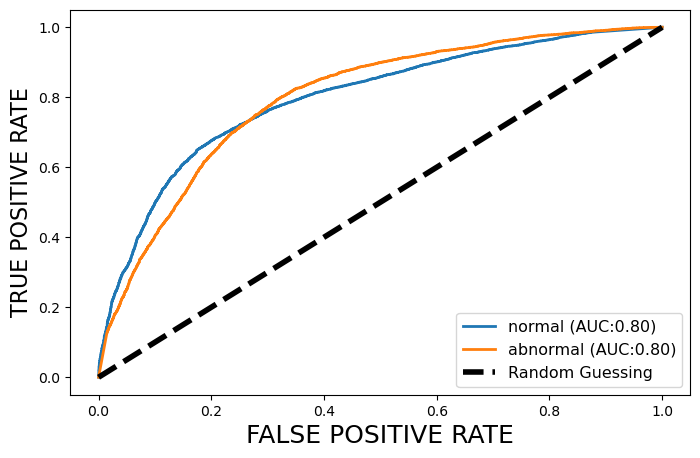

In [50]:
#preds = model.predict(test_generator)
#y_test = test_generator.classes
CLASS_LABELS = ["normal", "abnormal"]
fig, c_ax = plt.subplots(1,1, figsize = (8,5))

def multiclass_roc_auc_score(y_true, y_pred, average="macro"):    
    y_true = tf.keras.utils.to_categorical(y_true, dtype='float32')
    
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_true[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_true, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_val , val_pred  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()

ROC AUC score: 0.9702876538546737


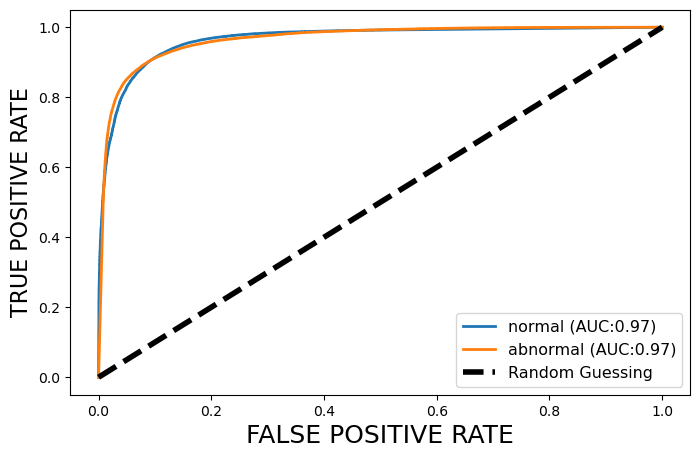

In [51]:
#preds = model.predict(test_generator)
#y_test = test_generator.classes
fig, c_ax = plt.subplots(1,1, figsize = (8,5))

print('ROC AUC score:', multiclass_roc_auc_score(y , y_pred  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()